In [231]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import doctest # To test the code with the examples in the docstring of the functions
import os
from PIL import Image
import tensorflow as tf
# To avoid the warning of tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras

# II.B. Eigenface Method

In [217]:
def averageFace(Q : np.ndarray) -> np.ndarray :
    """
    Compute the average face of a set of images (sketches or photos)

    Parameters
    ----------
    Q : np.array
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images.

    Returns
    -------
    np.array
        A 2D numpy array of shape (n, 1) containing the average face.
    """
    return np.mean(Q, axis=1).reshape(-1,1)

def eigenfaces(Q : np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray] :
    """
    Implementation of the eigenfaces algorithm

    Parameters
    ----------
    Q : np.ndarray
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (n, m) containing the eigenfaces
    np.ndarray
        A 2D numpy array of shape (n, m) containing the eigenvectors
    np.ndarray
        A 2D numpy array of shape (m, m) containing the matrix of eigenvalues after transformations

    >>> eigenfaces(np.array([[2,0],[0,5]]))[0].shape
    (2, 2)

    """
    # Compute the mean of the columns of Q (mean image)
    mp = averageFace(Q)
    # Subtract the mean from each column of Q
    Ap = Q - mp
    # Compute eigenvector matrix and eigenvalues of Atp*Ap
    eigvals, Vp = np.linalg.eig(np.matmul(Ap.transpose(),Ap))

    # Compute the orthormal eigenvector matrix of the covariance matrix
    eigPower = np.linalg.inv(sp.linalg.sqrtm(np.diag(eigvals)))
    Up = np.matmul(np.matmul(Ap,Vp),eigPower)

    return Up, Vp, eigPower

def featuresEigenfaces(Up : np.ndarray, P : np.ndarray) -> np.ndarray :
    """
    Implementation of the featuresEigenfaces algorithm.

    Parameters
    ----------
    Up : np.ndarray
        A 2D numpy array of shape (n, m) containing the eigenfaces.
    P : np.ndarray
        A 2D numpy array of shape (n, k) where n is the number of pixels in each image and k is the number of images.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (m, k) containing the features of the images.
    """
    return Up.T @ P

In [218]:
# use doctest to test the functions
doctest.testmod(verbose=True)

Trying:
    eigenfaces(np.array([[2,0],[0,5]]))[0].shape
Expecting:
    (2, 2)
ok
21 items had no tests:
    __main__
    __main__.Dataset
    __main__.Dataset.__init__
    __main__.Dataset.train_test_split
    __main__.Results
    __main__.Results.__init__
    __main__.Results.top_k
    __main__.averageFace
    __main__.denormalize
    __main__.featuresEigenfaces
    __main__.getData
    __main__.getPhotoSetsAI
    __main__.load
    __main__.normalize
    __main__.plotResults
    __main__.plot_sk_recognition
    __main__.pseudoSketchTransfo
    __main__.resize
    __main__.rgb2gray
    __main__.run_cross_validation
    __main__.sketch_recognition
1 items passed all tests:
   1 tests in __main__.eigenfaces
1 tests in 22 items.
1 passed and 0 failed.
Test passed.


TestResults(failed=0, attempted=1)

In [219]:
def getData(path : str) -> tuple[np.ndarray, list[str]]:
    """
    Reads the images data in the given path and returns it as a numpy array (each column represent an image)

    Parameterscould not find all required packages: libalpm.so >=14
    ----------
    path : str
        The path to the directory containing the images data.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images.
    list
        A list containing the filenames of the images.
    """
    # Initialize the array of images
    dir = os.listdir(path)
    dir.sort()
    img = Image.open(path + dir[0])
    # if image has 3 channels, convert it to grayscale
    img = img.convert('L') if len(np.array(img).shape) == 3 else img

    nbPixels = np.array(img).flatten().shape

    images = np.empty((nbPixels[0],len(dir)))

    # Shuffle the images with a given seed (guarantee reproducibility of the results and the
    # same order for photos/sketches)
    rd = np.random.RandomState(42)
    rd.shuffle(dir)
    filenames: list[str] = []
    for i,filename in enumerate(dir):
        img = Image.open(path + filename)
        # if image has 3 channels, convert it to grayscale
        img = img.convert('L') if len(np.array(img).shape) == 3 else img
        images[:,i] = np.array(img).flatten().transpose()

        filenames.append(filename)

    return images, filenames

def plotResults(inputRGB : np.ndarray,inputGrayscale : np.ndarray, pseudoSketch : np.ndarray, imageName : str, sketchPath : str):
    """
    Create a plot of three subplots to show the results

    Parameters
    ----------
    inputRGB : np.ndarray
        A 3D numpy array of shape (n, m, 3) containing the input RGB image.
    inputGrayscale : np.ndarray
        A 2D numpy array of shape (n*m) containing the input grayscale image.
    pseudoSketch : np.ndarray
        A 2D numpy array of shape (n*m) containing the pseudo-sketch image.

    Returns
    -------
    None
    """
    size = inputRGB.shape[0:2]

    fig, ax = plt.subplots(2,2)
    ax[0,0].imshow(inputRGB)
    ax[0,0].set_title('Original Image')
    ax[0,0].axis('off')

    ax[0,1].imshow(inputGrayscale.reshape(size),cmap='gray')
    ax[0,1].set_title('Grayscale Image')
    ax[0,1].axis('off')

    ax[1,0].imshow(pseudoSketch.reshape(size),cmap='gray')
    ax[1,0].set_title('Pseudo-sketch Image')
    ax[1,0].axis('off')

    ax[1,1].imshow(np.array(Image.open(sketchPath + imageName)),cmap='gray')
    ax[1,1].set_title('Real sketch Image')
    ax[1,1].axis('off')

    plt.show()

# III.A. Photo-to-Sketch Transformation

> In this section, we reimplement the III.A part of the article, following the 6 steps described

In [220]:
PHOTO_PATH = "./data/photos/"
SKETCH_PATH = "./data/sketches/"

class Dataset:
    def __init__(self, photoPath: str, sketchPath: str, n_splits: int = 5) -> None:
        """
        Creates cross-validation dataset with photos and sketches

        Parameters
        ----------
        photoPath: str
            Path to the photos directory
        sketchPath: str
            Path to the sketches directory
        n_splits: int
            Number of splits testing will be 1/n_splits of the data (default: 5) (80/20)
        """
        self.photoSet, self.photoNames = getData(photoPath)
        self.sketchSet, self.sketchNames = getData(sketchPath)
        trains, tests = Dataset.train_test_split(self.photoSet.shape[1], n_splits)

        self.train_id, self.test_id = trains, tests

        # List of training and testing sets for photos and sketches with cross validation
        self.photo_trains = [self.photoSet[:, train] for train in trains]
        self.photo_tests = [self.photoSet[:, test] for test in tests]
        self.sketch_trains = [self.sketchSet[:, train] for train in trains]
        self.sketch_tests = [self.sketchSet[:, test] for test in tests]

        # Default training and testing sets (for no cross-validation)
        self.photo_train_default = self.photo_trains[-1]
        self.photo_test_default = self.photo_tests[-1]
        self.sketch_train_default = self.sketch_trains[-1]
        self.sketch_test_default = self.sketch_tests[-1]


    @staticmethod
    def train_test_split(n_data: int, n_splits: int = 5
                     ) -> tuple[list[np.ndarray], list[np.ndarray]]:
        """
        Generate training and testing sets for cross-validation

        Parameters
        ----------
        n_data: int
            Size of the dataset
        n_splits: int
            Number of splits testing will be 1/n_splits of the data (default: 5) (80/20)

        Returns
        -------
        list
            List of training sets
        list
            List of testing sets
        """
        splits = np.array_split(np.arange(n_data), n_splits)
        splits_train = []
        splits_test = []
        for k in range(n_splits):
            splits_train.append(np.concatenate([splits[i] for i in range(n_splits) if i != k]))
            splits_test.append(splits[k])
        return splits_train, splits_test


def pseudoSketchTransfo(phototrainingSet : np.ndarray, sketchtrainingSet : np.ndarray, inputImages : np.ndarray) -> np.ndarray:
    """
    Implementation of the pseudoSketchTransfo algorithm.

    Parameters
    ----------
    phototrainingSet : np.ndarray
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images.
    sketchtrainingSet : np.ndarray
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images.
    inputImage : np.ndarray
        A 2D numpy array of shape (n, d) containing the input images, where d is the number of images.

    Returns
    -------
    np.array
        A 2D numpy array of shape (n, d) containing the pseudo-sketch images for each input image.
    """

    # Step 1
    mp = averageFace(phototrainingSet)
    ms = averageFace(sketchtrainingSet)

    # Step 2
    Ap = phototrainingSet - mp
    Up, Vp, eigPower = eigenfaces(Ap)

    # Step 3 adapted to multiple input images
    Pk = inputImages - mp

    # Step 4 adapted to multiple input images
    bp = featuresEigenfaces(Up, Pk)

    # Step 5 : Reconstruction of the pseudo-sketch
    As = sketchtrainingSet - ms
    Sr = As @ Vp @ eigPower @ bp

    # Step 6
    Tr = Sr + ms

    # Get the real part of the image and plot the results
    return Tr.real

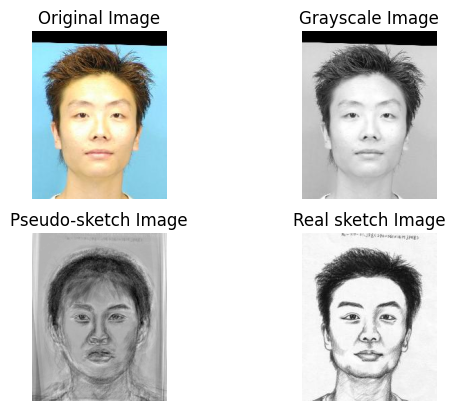

In [221]:
dataset = Dataset(PHOTO_PATH, SKETCH_PATH, 5)

pseudoSketch = pseudoSketchTransfo(
    dataset.photo_train_default,
    dataset.sketch_train_default,
    dataset.photo_test_default[0])

image_name = dataset.photoNames[dataset.test_id[-1][0]]

plotResults(
    np.array(Image.open(PHOTO_PATH + image_name)),
    dataset.photo_test_default[:,0],
    pseudoSketch[:,0],
    image_name,
    SKETCH_PATH)


# III.B. Sketch Recognition

In [148]:
def getPhotoSetsAI(imageNames : list[str], imageSet : np.ndarray) -> tuple[np.ndarray, list[str], np.ndarray, list[str]] :
    """

    Args
    ----
    imageNames : list
        A list containing the filenames of the images.
    imageSet : np.ndarray
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (n, m) containing the training set of the photos.
    list
        A list containing the filenames of the training set of the photos.
    np.ndarray
        A 2D numpy array of shape (n, m) containing the testing set of the photos.
    list
        A list containing the filenames of the testing set of the photos.
    """

    with open('test_names.txt') as f:
        testNames = f.readlines()
    with open('train_names.txt') as f:
        trainNames = f.readlines()
    indexTest = [imageNames.index(name[:-1]) for name in testNames]
    indexTrain = [imageNames.index(name[:-1]) for name in trainNames]

    return imageSet[:,indexTrain], [imageNames[i] for i in indexTrain], imageSet[:,indexTest], [imageNames[i] for i in indexTest]

In [164]:
# Choose between the AI implementation and the article implementation
ARTICLE_IMPLEMENTATION = False

In [165]:
# Get the data then split into training and testing sets for the photos
photoNames = dataset.photoNames
sketchNames = dataset.sketchNames

if ARTICLE_IMPLEMENTATION:
    phototrainingSet = dataset.photo_train_default
    phototestingSet = dataset.photo_test_default

    sketchtrainingSet = dataset.sketch_train_default
    sketchtestingSet = dataset.sketch_test_default
else :
    phototrainingSet, photoTrainNames, phototestingSet, photoTestNames  = getPhotoSetsAI(photoNames, dataset.photoSet)
    sketchtrainingSet, sketchTrainNames, sketchtestingSet, sketchTestNames = getPhotoSetsAI(sketchNames, dataset.sketchSet)

In [166]:
# Step 1 : Photo eigenspace
mp = averageFace(phototrainingSet)
Ap = phototrainingSet - mp
Up, Vp, eigPowerP = eigenfaces(Ap)

# Step 2 : Sketch eigenspace
ms = averageFace(sketchtrainingSet)
As = sketchtrainingSet - ms
Us, Vs, eigPowerS = eigenfaces(As)


### Étape 3 : deux cas possibles en fonction de si utilisation d'IA ou de l'implémentation directe de l'article

> Reprise des fonctions nécessaires du fichier Pix2Pix.ipynb dans lequel a été entrainé le modèle

In [176]:
class Results:
    def __init__(self, SrAll: np.ndarray, PrAll: np.ndarray, min_d1: np.ndarray, min_d2: np.ndarray, min_d3: np.ndarray) -> None:
        self.SrAll = SrAll
        self.PrAll = PrAll
        self.d1 = min_d1
        self.d2 = min_d2
        self.d3 = min_d3
        self.size = self.d1.shape[1]

    def top_k(self, k: int = 10) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Get the top k of the distances summed for d1, d2 and d3

        Args
        ----
        k : int
            The top k to consider

        Returns
        -------
        tuple
            The top k cumulated scores for d1, d2 and d3
        """
        d1 = np.zeros((self.size,k), dtype=bool)
        d2 = np.zeros_like(d1)
        d3 = np.zeros_like(d1)
        for i in range(self.size):
            for j in range(k):
                d1[i,j] = i in self.d1[i,:j+1]
                d2[i,j] = i in self.d2[i,:j+1]
                d3[i,j] = i in self.d3[i,:j+1]
        top_k1 = np.round(np.sum(d1, axis=0)/self.size * 100)
        top_k2 = np.round(np.sum(d2, axis=0)/self.size * 100)
        top_k3 = np.round(np.sum(d3, axis=0)/self.size * 100)
        return top_k1, top_k2, top_k3

In [232]:
def resize(image, height, width):
    """
    Origine de la fonction : Pix2Pix
    Pour redimensionner les images à la taille souhaitée
    """
    image = tf.image.resize(image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

def denormalize(image):
    image = (image+1)
    image = image*127.5
    return image

def normalize(image):
    image = (image/ 127.5) - 1
    return image

def load(image_path):
    """ Lecture à l'aide de tensorflow des images"""
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image,channels=3)
    image = tf.cast(image, tf.float32)
    return image

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

# Step 3 : Pseudo-sketch transformation for each photo of the testing set
if ARTICLE_IMPLEMENTATION :
    SrAll = pseudoSketchTransfo(phototrainingSet, sketchtrainingSet, phototestingSet)
    PrAll = pseudoSketchTransfo(sketchtrainingSet, phototrainingSet, sketchtestingSet)
else :
    model = keras.models.load_model('./PortraitToSketch.keras')
    size = np.array(Image.open(PHOTO_PATH + photoTestNames[0])).shape[0:2]
    SrAll = np.zeros((size[0]*size[1], phototestingSet.shape[1]))
    PrAll = np.zeros((size[0]*size[1], sketchtestingSet.shape[1]))

    for i, filename in enumerate(photoTestNames):
        image = normalize(resize(load(PHOTO_PATH + filename),256,256)) # Récupération de l'image et normalisation pour le modèle
        image = tf.convert_to_tensor(image)

        modelOutput = model.predict(image[tf.newaxis, ...], verbose = 0)[0]

        modelOutput = tf.cast(denormalize(modelOutput), tf.int32)
        modelOutput = tf.clip_by_value(modelOutput,0,255)

        pseudoSketch = rgb2gray(resize(modelOutput[tf.newaxis, ...], size[0], size[1])[0]) # Obtention du pseudo-sketch de la bonne taille et en noir et blanc

        SrAll[:,i] = np.array(pseudoSketch).flatten()


(47, 47)
[ 96. 100. 100.]


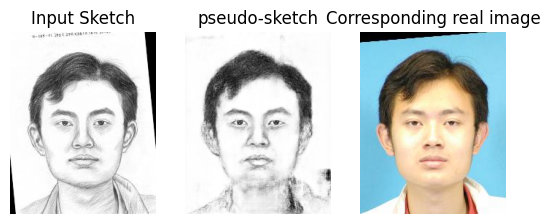

In [183]:
# Step 4 : Compute the eigensketch weight vector for each pseudo-sketch
br = featuresEigenfaces(Us, SrAll)

# Step 5 : same thing but with the testing sketch (here, the first of the testing set)
if ARTICLE_IMPLEMENTATION :
    bs = featuresEigenfaces(Us, sketchtestingSet[:,0].reshape(-1,1))
else:
    bs = featuresEigenfaces(Us, sketchtestingSet)

# Step 6 : Compute the distances
## We first need each vector of reconstruction coefficients cp (and cs)
cs = Vs @ eigPowerS @ bs
# bp is the vector of reconstruction coefficients of the pseudo-sketch
bp = featuresEigenfaces(Up, PrAll)

lambda_p = np.linalg.inv(eigPowerP)
lambda_s = np.linalg.inv(eigPowerS)

cp = Vs @ eigPowerS @ br

# Number of sketches used for testing
n_sketches = 1 if ARTICLE_IMPLEMENTATION else sketchtestingSet.shape[1]

d1: np.ndarray = np.zeros((n_sketches, phototestingSet.shape[1]))
d2: np.ndarray = np.zeros_like(d1)
d3: np.ndarray = np.zeros_like(d1)

# Computing the distances to all the pseudo-sketches for each sketch
for i in range(n_sketches):
    d1[i] = np.linalg.norm(cp - cs[:,i].reshape(-1,1), axis=0)
    d2[i] = np.linalg.norm(lambda_s @ Vs.T @ (cp - cs[:,i].reshape(-1,1)), axis=0)
    d3[i] = np.linalg.norm(lambda_p @ Vp.T @ (cp - cs[:,i].reshape(-1,1)), axis=0)
min_d1 = np.argsort(d1, axis=1)
min_d2 = np.argsort(d2, axis=1)
min_d3 = np.argsort(d3, axis=1)

result = Results(SrAll, PrAll, min_d1, min_d2, min_d3)
## Get the real sketch and plot the results
minIndex = min_d2[0,0]

print(d1.shape)
# Sketch given to the model
inputSketch = sketchtestingSet[:,0]
sketchName = sketchTestNames[0]
# Sketch judged as the closest to the pseudo-sketch
pseudoSketchFound = SrAll[:,minIndex]
# Original image corresponding to the sketch
imageName = photoTestNames[0]
imageResult = np.array(Image.open(PHOTO_PATH + imageName))

size = imageResult.shape[0:2]
fig, ax = plt.subplots(1,3)

ax[0].imshow(inputSketch.reshape(size), cmap='gray')
ax[0].set_title('Input Sketch')
ax[0].axis('off')
ax[1].imshow(pseudoSketchFound.reshape(size),cmap='gray')
ax[1].set_title('pseudo-sketch')
ax[1].axis('off')
ax[2].imshow(imageResult,cmap='gray')
ax[2].set_title('Corresponding real image')
ax[2].axis('off')

_, top_k, _ = result.top_k(3)
print(top_k)
plt.show()

The person has been recognized !


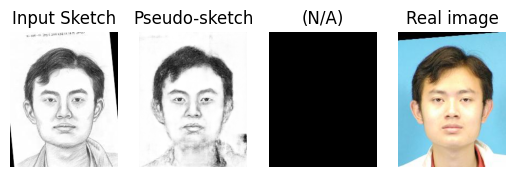

In [160]:
def plot_sk_recognition(in_sketch, in_photo, SrAll, PrAll, argmins: np.ndarray):
    size = (250, 200)
    _, ax = plt.subplots(1,4)
    minIndex = argmins[0]
    ax[0].imshow(in_sketch.reshape(size), cmap='gray')
    ax[0].set_title('Input Sketch')
    ax[0].axis('off')
    ax[1].imshow(SrAll[:,minIndex].reshape(size),cmap='gray')
    ax[1].set_title('Pseudo-sketch')
    ax[1].axis('off')
    if ARTICLE_IMPLEMENTATION:
        ax[2].imshow(PrAll[:,minIndex].reshape(size),cmap='gray')
        ax[2].set_title('Pseudo-photo')
        ax[2].axis('off')
    else:
        ax[2].imshow(PrAll[:,minIndex].reshape(size),cmap='gray')
        ax[2].set_title('(N/A)')
        ax[2].axis('off')
    ax[3].imshow(in_photo,cmap='gray')
    ax[3].set_title('Real image')
    ax[3].axis('off')
    if minIndex == 0:
        print("The person has been recognized !")
    elif 0 in argmins:
        k = np.where(argmins == 0)[0][0]
        print(f"The person has not been recognized but is in the top 10 at position {k}")
    else:
        print("The person has not been recognized")
    plt.show()

plot_sk_recognition(inputSketch, imageResult, SrAll, PrAll, min_d2)

### Top-k images

In [222]:
def sketch_recognition(dataset:Dataset, set_id: int, k: int = 10, enable_eig: bool = False) -> Results:
    """Computes the sketch recognition algorithm

    Args
    ----
    dataset : Dataset
        The dataset containing the photos and sketches
    set_id : int
        The index of the set to use
    k : int
        The top k to consider
    enable_eig : bool
        Enable the use of the eigenfaces algorithm

    Returns
    -------
    Results
        The results of the sketch recognition algorithm
    """
    ph_train = dataset.photo_trains[set_id]
    ph_test = dataset.photo_tests[set_id]
    sk_train = dataset.sketch_trains[set_id]
    sk_test = dataset.sketch_tests[set_id]

    # Step 1 : Photo eigenspace
    mp = averageFace(ph_train)
    Ap = ph_train - mp
    Up, Vp, eigPowerP = eigenfaces(Ap)

    # Step 2 : Sketch eigenspace
    ms = averageFace(sk_train)
    As = sk_train - ms
    Us, Vs, eigPowerS = eigenfaces(As)


    # Step 3 : Pseudo-sketch transformation for each photo of the testing set
    SrAll = pseudoSketchTransfo(ph_train, sk_train, ph_test) - ms
    PrAll = pseudoSketchTransfo(sk_train, ph_train, sk_test) - mp

    # Step 4 : Compute the eigensketch weight vector for each pseudo-sketch
    br = featuresEigenfaces(Us, SrAll)

    # Step 5 : same thing but with the testing sketch
    bs = featuresEigenfaces(Us, sk_test - ms)

    bp = featuresEigenfaces(Up, ph_test - mp)

    # Step 6 : Compute the distances
    ## We first need each vector of reconstruction coefficients cp (and cs)
    cs = Vs @ eigPowerS @ bs

    cp = Vs @ eigPowerS @ br

    if not enable_eig:
        d1: np.ndarray = np.zeros((sk_test.shape[1], ph_test.shape[1]))
        d2: np.ndarray = np.zeros_like(d1)
        d3: np.ndarray = np.zeros_like(d1)
    else:
        eig_dist = np.zeros((sk_test.shape[1], ph_test.shape[1]))
    lambda_p = np.linalg.inv(eigPowerP)
    lambda_s = np.linalg.inv(eigPowerS)

    # Computing the distances to all the pseudo-sketches for each sketch
    if not enable_eig:
        for i in range(sk_test.shape[1]):
            d1[i] = np.linalg.norm(cp - cs[:,i].reshape(-1,1), axis=0)
            d2[i] = np.linalg.norm(lambda_s @ Vs.T @ (cp - cs[:,i].reshape(-1,1)), axis=0)
            d3[i] = np.linalg.norm(lambda_p @ Vp.T @ (cp - cs[:,i].reshape(-1,1)), axis=0)
        min_d1 = np.argsort(d1, axis=1)
        min_d2 = np.argsort(d2, axis=1)
        min_d3 = np.argsort(d3, axis=1)
    else:
        bp_eig = featuresEigenfaces(Up, ph_test - mp)
        bs_eig = featuresEigenfaces(Up, sk_test - ms)
        for i in range(sk_test.shape[1]):
            eig_dist[i] = np.linalg.norm(bp_eig - bs_eig[:,i].reshape(-1,1), axis=0)
        min_eig = np.argsort(eig_dist, axis=1)

    return Results(SrAll, PrAll, min_d1, min_d2, min_d3) if not enable_eig else Results(SrAll, PrAll, min_eig, min_eig, min_eig)

def run_cross_validation(dataset: Dataset, k: int = 10) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    results: list[Results] = []
    for i in range(len(dataset.photo_trains)):
        results.append(sketch_recognition(dataset, i, k))

    return results

In [205]:
dataset = Dataset(PHOTO_PATH, SKETCH_PATH, 2)
result = sketch_recognition(dataset, 0)

In [206]:
tops = result.top_k(10)
print(tops[0])
print(tops[1])
print(tops[2])

[23. 30. 35. 36. 36. 36. 38. 38. 39. 39.]
[65. 71. 73. 78. 78. 81. 85. 87. 87. 89.]
[60. 64. 69. 72. 74. 77. 77. 78. 80. 83.]


In [207]:
dataset = Dataset(PHOTO_PATH, SKETCH_PATH, 5)
TOP_K = 10
results = run_cross_validation(dataset, TOP_K)

In [209]:
top_k1, top_k2, top_k3 = np.zeros(TOP_K), np.zeros(TOP_K), np.zeros(TOP_K)
for i, result in enumerate(results):
    top_k1_loc, top_k2_loc, top_k3_loc = result.top_k(TOP_K)
    top_k1 += top_k1_loc
    top_k2 += top_k2_loc
    top_k3 += top_k3_loc
top_k1 /= len(results)
top_k2 /= len(results)
top_k3 /= len(results)

print("General Statistics")
print(f"Top {TOP_K} for d1 : {top_k1}")
print(f"Top {TOP_K} for d2 : {top_k2}")
print(f"Top {TOP_K} for d3 : {top_k3}")

General Statistics
Top 10 for d1 : [62.8 73.8 78.6 82.6 83.6 84.8 85.2 85.2 86.8 87.2]
Top 10 for d2 : [75.4 84.6 89.8 91.4 92.4 94.  94.6 95.2 96.4 98.4]
Top 10 for d3 : [63.4 76.  79.8 84.6 87.  89.  89.6 90.2 90.2 91.4]


In [227]:
dataset = Dataset(PHOTO_PATH, SKETCH_PATH, 2)
results_eig = sketch_recognition(dataset, 0, enable_eig=True)

In [228]:
print(results_eig.top_k(10)[0])

[59. 65. 72. 76. 79. 80. 82. 82. 82. 82.]


In [ ]:

# TODO: Implement
from enum import Enum

class RunType(Enum):
    CROSS_VALIDATION = 1
    SINGLE_RUN = 2
    EIGENFACES = 3
    AI = 4